In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

In [ ]:
# true metric
m_star = (-0.94,-0.34) #200 degree
# m_star = (0.98,0.17) #11.47 degree

m_star = m_star/np.linalg.norm(m_star)  # normalize
# obtain true theta
t_true = np.arccos(m_star[0])
if t_true > np.pi/2:  # make sure theta either in [0, pi/2] or [pi, 3/2*pi]
    t_true = np.pi*2-t_true

print(t_true)

def eta(x):
  return 1/(1+np.exp(5*x))

zeta = 0.5  # f_X /sim U(-1,1)

# implementation of proposition 1
# return a classifier with t
def h_bar(t):
  m11, m00 = np.cos(t), np.sin(t)
  def hb(x):
    if m11+m00 >= 0:
      return int(eta(x)>=m00/(m11+m00))
    else:
      return int(eta(x)<=m00/(m11+m00))
  return hb

# confusion matrix, analytical solution
def C11(t):  # P(Y=1, h=1)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0.
  h = h_bar(t)
  if m00 == 0:
    x_prime = 1
  elif (m00+m11)/m00-1 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return 0.5*(x_prime-0.2*np.log(1+np.exp(5*x_prime))+1+0.2*np.log(1+np.exp(-5))) # x-0.2ln(1+e^5x)
  else:
    return 0.5*(1-0.2*np.log(1+np.exp(5))-x_prime+0.2*np.log(1+np.exp(5*x_prime)))

def C10(t):  # P(Y=0, h=1)
  return 0.5-C11(t)

def C01(t):  # P(Y=1, h=0)
  return 0.5-C00(t)

def C00(t):  # P(Y=0, h=0)
  m11,m00 = np.cos(t), np.sin(t)
  x_prime = 0
  h = h_bar(t)
  if m00 == 0:
    x_prime = 1
  elif (m00+m11)/m00-1 <= 0:
    x_prime = -1
  else:
    x_prime = np.log(m11/m00)/5
    if x_prime > 1:
      x_prime = 1
    elif x_prime < -1:
      x_prime = -1
  if m00+m11 >= 0:
    return 0.5*(0.2*np.log(1+np.exp(5))-0.2*np.log(1+np.exp(5*x_prime)))  # ln(1+e^5x)
  else:
    return 0.5*(0.2*np.log(1+np.exp(5*x_prime))-0.2*np.log(1+np.exp(-5)))

# metric evaluation
def phi(t):
  m11, m00 = np.cos(t_true), np.sin(t_true)
  return m11*C11(t)+m00*C00(t)

# query function
def query(t_1, t_2, alpha):
  # if abs(phi(t_1)-phi2(m_star[0], m_star[1])) > abs(phi(t_2)-phi2(m_star[0], m_star[1])):
  if phi(t_1) < phi(t_2):
    return 1  # prefer t2
  else:
    return 0  # prefer t1

# implements algorithm 1
# analytical version
# alpha: error rate of oracle
def max_quasiconcave_metric(eps, alpha):
  t_a = np.pi
  t_b = np.pi*1.5
  m_bar = np.zeros(2)
  C_bar = 0
  iter = 0
  while np.linalg.norm(t_a-t_b) > eps:
    t_c = (3*t_a+t_b)/4
    t_d = (t_a+t_b)/2
    t_e = (t_a+3*t_b)/4
    C_a = np.array([[C00(t_a), C01(t_a)],[C10(t_a), C11(t_a)]])
    C_b = np.array([[C00(t_b), C01(t_b)],[C10(t_b), C11(t_b)]])
    C_c = np.array([[C00(t_c), C01(t_c)],[C10(t_c), C11(t_c)]])
    C_d = np.array([[C00(t_d), C01(t_d)],[C10(t_d), C11(t_d)]])
    C_e = np.array([[C00(t_e), C01(t_e)],[C10(t_e), C11(t_e)]])
    ca = query(t_c, t_a, alpha)
    dc = query(t_d, t_c, alpha)
    ed = query(t_e, t_d, alpha)
    be = query(t_b, t_e, alpha)
    if ca:
      t_b = t_d
    elif not ca and dc:
      t_b = t_d
    elif not dc and ed:
      t_a = t_c
      t_b = t_e
    elif not ed and be:
      t_a = t_d
    else:
      t_a = t_d
    m_bar[0], m_bar[1] = np.cos(t_d), np.sin(t_d)
    C_bar = C_d
    iter += 1
  # print("iteration run:"+str(iter))
  return m_bar,C_bar

3.4886542571292836


In [ ]:
m,C = max_quasiconcave_metric(1e-4, 0.)
print("true metric: "+str(m_star))
print("elicited metric: "+str(m))
print("confusion matrix: \n"+str(C))

true metric: [-0.94037623 -0.34013608]
elicited metric: [-0.9403757  -0.34013754]
confusion matrix: 
[[0.13189508 0.36810492]
 [0.46979786 0.03020214]]


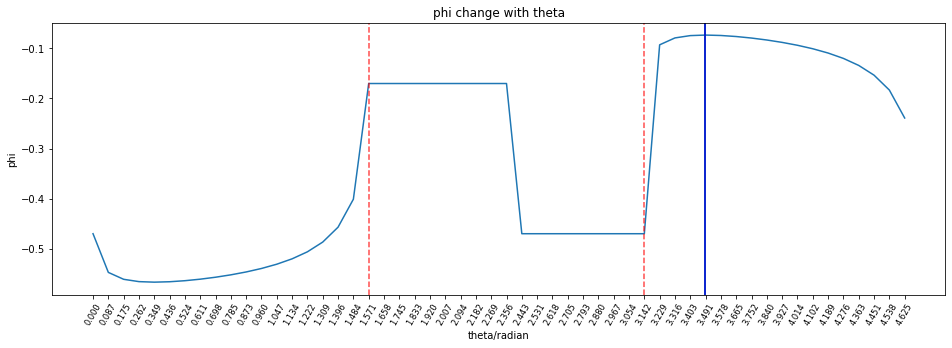

In [ ]:
# Plot phi function versus different thetas
ph = []
for i in np.arange(0, np.pi*1.5, np.pi/36):
  ph.append(phi(i))

plt.figure(figsize=(16,5))
plt.plot(np.arange(0, np.pi*1.5, np.pi/36), ph, "-")
for p in np.arange(0.5, 1.5, 0.5):
  plt.axvline(x=np.pi*p, c='r', ls='--', alpha=0.7)
plt.axvline(x=t_true, c='g')
t_elicited = np.arccos(m[0])
if t_elicited > np.pi/2:  # make sure theta either in [0, pi/2] or [pi, 3/2*pi]
    t_elicited = np.pi*2-t_elicited
plt.axvline(x=t_elicited, c='b')
# plt.axvline(x=np.arccos(np.pi/4), c='black')
plt.xticks(np.arange(0, np.pi*1.5, np.pi/36), rotation=60, size="small")
plt.title("phi change with theta")
plt.xlabel("theta/radian")
plt.ylabel("phi")
plt.show()

In [ ]:
C11(np.arccos(m_star[0]))

0.484675069879644

In [ ]:
C11(np.arccos(m_star[0]))
h = h_bar(np.arccos(m_star[0]))